In [ ]:
import pandas as pd
data = pd.read_csv("every_worker.csv",encoding='utf-8-sig')

In [ ]:
data = data[['pid','year','p_age','p_econstat','p_edu','p_job_status','p_job_begin','p_employ_type','p_hours','job_name','산업명','p_jobtype','p_sex','p_wage']]

In [ ]:
data = data.dropna()#40444개 ->39774개

In [ ]:
def age_group(age):
    if age <= 29:
        return 1
    elif age <= 39:
        return 2
    elif age <= 49:
        return 3
    elif age <= 59:
        return 4
    else:
        return 5

In [ ]:
def map_edu(val):
    if val in [1, 2]:
        return 1
    elif val == 3:
        return 2
    elif val in [4, 5]:
        return 3
    elif val == 6:
        return 4
    else:
        return pd.NA  # 결측치 처리

In [ ]:
data["hourly_wage"] = (data["p_wage"]*10000) / (data["p_hours"] * 4.345)
data['year'] = pd.to_numeric(data['year'], errors='coerce')
data['p_job_begin'] = data['p_job_begin'].str.replace(r'm.*', '', regex=True)
data['p_job_begin'] = pd.to_numeric(data['p_job_begin'], errors='coerce')
data['경력기간'] = data['year'] - data['p_job_begin']
data['경력기간'] = data.groupby('pid')['경력기간'].transform('max')
data['different_year'] = data['year'].map({2017: 0, 2018: 1, 2019: 0, 2020: 1})
data['p_sex'] = data['p_sex'].map({1: 0, 2: 1})
data['p_age'] = data['p_age'].apply(age_group)
data['p_edu'] = data['p_edu'].apply(map_edu)
data['p_job_status'] = data['p_job_status'].replace(2, 0)
data = data[~data['p_job_status'].isin([3, 4, 5])].copy()

## 업종, 직종 전처리

In [ ]:
# 2. 직종 분류 함수
def classify_job(job_name):
    if pd.isna(job_name):
        return "기타"
    elif any(x in job_name for x in ["관리", "전문", "연구", "의사", "변호사", "교수", "엔지니어", "기획"]):
        return "관리자, 전문가 및 관련종사자"
    elif any(x in job_name for x in ["사무", "행정", "회계", "총무", "비서"]):
        return "사무종사자"
    elif any(x in job_name for x in ["판매", "서비스", "요리", "식당", "접객", "농업", "어업", "호텔", "숙박"]):
        return "서비스, 판매종사자 등"
    elif any(x in job_name for x in ["기계", "조작", "조립", "정비", "운전", "생산", "설비", "제조", "전기", "공", "배선"]):
        return "기능, 기계조작, 조립종사자"
    elif any(x in job_name for x in ["청소", "미화", "노무", "단순", "경비", "하역"]):
        return "단순노무종사자"
    else:
        return "기타"

# 3. 업종 분류 함수
def classify_industry(ind_name):
    if pd.isna(ind_name):
        return "기타"
    elif any(x in ind_name for x in ["농업", "광업", "제조", "건설", "전기", "수도", "에너지"]):
        return "농업, 광업, 제조업, 전기, 수도, 건설"
    elif any(x in ind_name for x in ["도매", "소매", "유통", "운수", "물류", "택배", "숙박", "음식", "식당"]):
        return "도매, 운수, 숙박"
    elif any(x in ind_name for x in ["정보", "통신", "IT", "금융", "보험", "부동산", "관리", "시설"]):
        return "정보, 금융, 부동산, 시설관리"
    elif any(x in ind_name for x in ["교육", "병원", "보건", "의료", "공공", "연구", "대학", "행정"]):
        return "전문, 공공, 교육, 보건"
    elif any(x in ind_name for x in ["예술", "문화", "종교", "협회", "국제", "자가", "외교"]):
        return "예술, 협회, 자가, 국제"
    elif any(x in ind_name for x in ["청소", "방제", "환경", "위생"]):
        return "청소 및 환경관리 서비스"
    else:
        return "기타"

In [ ]:
# 4. 분류 적용
data['직종'] = data['job_name'].apply(classify_job)
data['업종'] = data['산업명'].apply(classify_industry)

## 최저임금영향집단, 최저임금미만집단 분류

In [ ]:
# 연도별 최저임금
min_wage_dict = {
    2017: 6470,
    2018: 7530,
    2019: 8350,
    2020: 8590
}

# 시급 대비 최저임금 비율 계산
data['minwage_ratio'] = data.apply(
    lambda row: row['hourly_wage'] / min_wage_dict.get(row['year'], 1)
    if pd.notna(row['hourly_wage']) else pd.NA,
    axis=1
)

# 개인별 연도별 시급 비율 pivot 테이블 생성
pivot = data.pivot_table(index='pid', columns='year', values='minwage_ratio')

# 함수 정의: 영향집단 vs 미만집단
def label_minwage_group(row):
    # 최저임금 영향집단
    cond_before = (row.get(2017, 0) >= 1.0) or (row.get(2019, 0) >= 1.0)
    cond_after  = (row.get(2018, 0) < 1.0) or (row.get(2020, 0) < 1.0)
    if cond_before and cond_after:
        return "최저임금 영향집단"

    # 최저임금 미만집단: 2017년 기준 80% 이상이며, 전체 연도 모두 0.8 이상
    min_all_above_80 = all((pd.isna(v) or v >= 0.8) for v in row)
    if row.get(2017, 0) >= 0.8 and min_all_above_80:
        return "최저임금 미만집단"

    # 나머지는 분석 제외
    return pd.NA

# 집단 부여
pivot['임금집단'] = pivot.apply(label_minwage_group, axis=1)

# 원본 데이터와 병합
data = data.merge(pivot[['임금집단']], left_on='pid', right_index=True, how='left')

In [ ]:
data1 = data[data['임금집단']=='최저임금 영향집단']
data2 = data[data['임금집단']=='최저임금 미만집단']
print(len(data1),len(data2))

2815 18360


In [ ]:
# 1. 나눔고딕 설치
!apt-get -qq install -y fonts-nanum

<ipython-input-70-5f5cc9b1fa70>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data1['고용형태'] = data1['p_job_status'].map({0: '비정규직', 1: '정규직'})


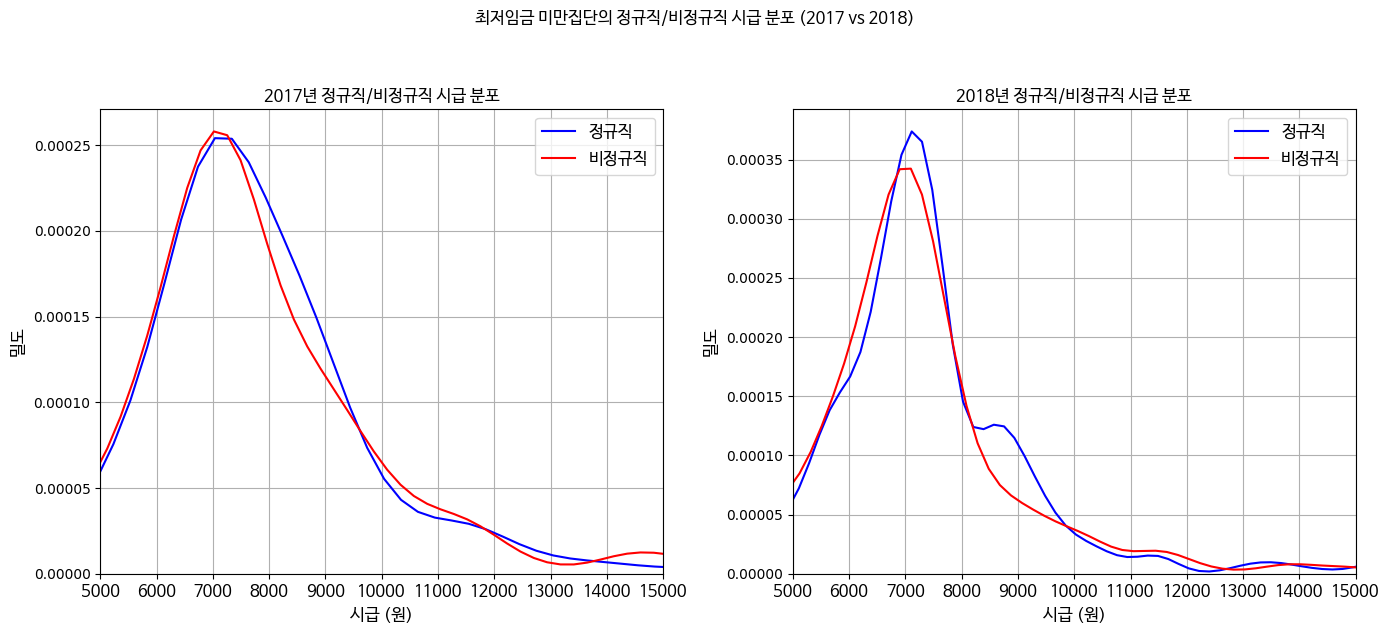

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
import numpy as np
# 바른고딕 폰트 설정
font_path = "/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf"
fontprop = fm.FontProperties(fname=font_path, size=12)
data1['고용형태'] = data1['p_job_status'].map({0: '비정규직', 1: '정규직'})

# KDE 시각화 개선
plt.figure(figsize=(14, 6))
years = [2017, 2018]

for i, year in enumerate(years, 1):
    plt.subplot(1, 2, i)
    subset = data1[data1['year'] == year]
    sns.kdeplot(data=subset[subset['고용형태'] == '정규직'], x='hourly_wage', label='정규직', color='blue', bw_adjust=0.5)
    sns.kdeplot(data=subset[subset['고용형태'] == '비정규직'], x='hourly_wage', label='비정규직', color='red', bw_adjust=0.5)
    plt.title(f"{year}년 정규직/비정규직 시급 분포", fontproperties=fontprop)
    plt.xlabel("시급 (원)", fontproperties=fontprop)
    plt.ylabel("밀도", fontproperties=fontprop)
    plt.legend(prop=fontprop)
    plt.grid(True)
    plt.xlim(5000, 15000)
    plt.xticks(np.arange(5000, 15500, 1000), fontproperties=fontprop)  # 👈 여기가 핵심!

plt.suptitle("최저임금 미만집단의 정규직/비정규직 시급 분포 (2017 vs 2018)", fontproperties=fontprop, y=1.05)
plt.tight_layout()
plt.show()

# 패널 회귀분석

In [ ]:
data1_pannel = data1[['pid','year','p_age','p_edu','p_job_status','경력기간','p_hours','직종','업종','p_sex','hourly_wage']]
data2_pannel = data2[['pid','year','p_age','p_edu','p_job_status','경력기간','p_hours','직종','업종','p_sex','hourly_wage']]

In [ ]:
#data1_pannel = data1_pannel.rename(columns={'job_name': '직종', '산업명': '업종'})
df_dummies = pd.get_dummies(
    data1_pannel,
    columns=['p_edu', 'p_age', '업종', '직종'],
    drop_first=True
)

#data1_pannel = data1_pannel.rename(columns={'job_name': '직종', '산업명': '업종'})
df_dummies2 = pd.get_dummies(
    data2_pannel,
    columns=['p_edu', 'p_age', '업종', '직종'],
    drop_first=True
)

In [ ]:
df_dummies.columns

Index(['pid', 'year', 'p_job_status', '경력기간', 'p_hours', 'p_sex',
       'hourly_wage', 'p_edu_2', 'p_edu_3', 'p_edu_4', 'p_age_2', 'p_age_3',
       'p_age_4', 'p_age_5', '업종_농업, 광업, 제조업, 전기, 수도, 건설', '업종_도매, 운수, 숙박',
       '업종_예술, 협회, 자가, 국제', '업종_전문, 공공, 교육, 보건', '업종_정보, 금융, 부동산, 시설관리',
       '업종_청소 및 환경관리 서비스', '직종_기능, 기계조작, 조립종사자', '직종_기타', '직종_단순노무종사자',
       '직종_사무종사자', '직종_서비스, 판매종사자 등', 'year_dummies'],
      dtype='object')

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

# 1. 조사년도 더미 생성
df_dummies['year_dummies'] = df_dummies['year'].map({2017: 0, 2018: 1, 2019: 0, 2020: 1})

# 2. 시급이 양수인 데이터만 선택
df_valid = df_dummies[df_dummies['hourly_wage'] > 0].copy()

# 3. 로그 시급 변수 생성
df_valid['log_hourly_wage'] = np.log(df_valid['hourly_wage'])

# 4. 조사년도 × 고용형태 상호작용 항 생성
df_valid['year**_p_jobstatus'] = df_valid['year_dummies'] * df_valid['p_job_status']

# 5. 독립변수 리스트 구성
X_vars = ['year_dummies', 'p_job_status', 'year**_p_jobstatus', '경력기간', 'p_hours']
X_vars += [col for col in df_valid.columns if col.startswith('p_edu_')]
X_vars += [col for col in df_valid.columns if col.startswith('p_age_')]
X_vars += [col for col in df_valid.columns if col.startswith('업종_')]
X_vars += [col for col in df_valid.columns if col.startswith('직종_')]

# 6. X, y 정의 및 float 변환
X = df_valid[X_vars].astype(float)
X = sm.add_constant(X)
y = df_valid['log_hourly_wage'].astype(float)

# 7. 회귀분석 수행
model = sm.OLS(y, X)
results = model.fit(cov_type='HC3')

In [ ]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        log_hourly_wage   R-squared:                       0.187
Model:                            OLS   Adj. R-squared:                  0.181
Method:                 Least Squares   F-statistic:                     18.65
Date:                Sun, 18 May 2025   Prob (F-statistic):           1.46e-70
Time:                        12:39:49   Log-Likelihood:                -600.20
No. Observations:                2809   AIC:                             1248.
Df Residuals:                    2785   BIC:                             1391.
Df Model:                          23                                         
Covariance Type:                  HC3                                         
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                          9.3942      0.049    192.630      0.000       9.299       9.490
year_dummies                  -0.1329      0.019     -6.931      0.000      -0.171      -0.095
p_job_status                   0.0667      0.019      3.526      0.000       0.030       0.104
year**_p_jobstatus             0.0528      0.024      2.200      0.028       0.006       0.100
경력기간                           0.0019      0.001      1.807      0.071      -0.000       0.004
p_hours                       -0.0084      0.001    -13.709      0.000      -0.010      -0.007
p_edu_2                        0.0681      0.014      4.717      0.000       0.040       0.096
p_edu_3                        0.1072      0.022      4.781      0.000       0.063       0.151
p_edu_4                        0.0986      0.027      3.633      0.000       0.045       0.152
p_age_2                       -0.0342      0.028     -1.229      0.219      -0.089       0.020
p_age_3                       -0.0220      0.024     -0.912      0.362      -0.069       0.025
p_age_4                        0.0160      0.026      0.622      0.534      -0.034       0.066
p_age_5                       -0.0538      0.028     -1.918      0.055      -0.109       0.001
업종_농업, 광업, 제조업, 전기, 수도, 건설     0.0171      0.018      0.958      0.338      -0.018       0.052
업종_도매, 운수, 숙박                 -0.0079      0.018     -0.439      0.661      -0.043       0.027
업종_예술, 협회, 자가, 국제             -0.0974      0.067     -1.448      0.148      -0.229       0.034
업종_전문, 공공, 교육, 보건              0.0325      0.026      1.234      0.217      -0.019       0.084
업종_정보, 금융, 부동산, 시설관리           0.0302      0.020      1.493      0.135      -0.009       0.070
업종_청소 및 환경관리 서비스               0.1144      0.033      3.426      0.001       0.049       0.180
직종_기능, 기계조작, 조립종사자            -0.0404      0.028     -1.442      0.149      -0.095       0.014
직종_기타                         -0.0983      0.030     -3.330      0.001      -0.156      -0.040
직종_단순노무종사자                    -0.0908      0.029     -3.153      0.002      -0.147      -0.034
직종_사무종사자                      -0.0696      0.037     -1.870      0.061      -0.143       0.003
직종_서비스, 판매종사자 등               -0.1336      0.031     -4.244      0.000      -0.195      -0.072
==============================================================================
Omnibus:                      654.549   Durbin-Watson:                   1.485
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            10517.927
Skew:                           0.662   Prob(JB):                         0.00
Kurtosis:                      12.387   Cond. No.                         481.
==============================================================================

Notes:
[1] Standard Errors are heteroscedas